In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List

def classify_student_type(row: pd.Series) -> str:
    """
    分类函数：判断学生是偏科型还是均衡型
    
    偏科型判定标准：
    1. 显著性过滤：强/弱知识点需满足最低题量阈值（≥5题）
       - 强项知识点：pk > 0.8 且 Nk ≥ 5
       - 弱项知识点：pk < 0.4 且 Nk ≥ 5
    2. 效应量评估：计算强项与弱项的Cohen's d值
       - 仅当 |d| > 0.8 时判定为显著偏科
    
    参数:
        row: 包含学生数据的pandas Series
    
    返回:
        str: "偏科型" 或 "均衡型"
    """
    # 解析数据并排除填充值-1
    all_concepts = [int(x) for x in row['concepts'].split(',')]
    all_responses = [int(x) for x in row['responses'].split(',')]
    
    # 过滤掉填充值-1
    valid_data = [(concept, response) for concept, response in zip(all_concepts, all_responses) 
                  if concept != -1 and response != -1]
    
    if not valid_data:
        return "均衡型"  # 如果没有有效数据，默认为均衡型
    
    concepts, responses = zip(*valid_data)
    concepts = list(concepts)
    responses = list(responses)
    
    # 计算每个概念的正确率和题量
    concept_accuracy = calculate_concept_accuracy(concepts, responses)
    
    # 显著性过滤：识别强项和弱项知识点
    strong_concepts = {}  # 强项知识点
    weak_concepts = {}    # 弱项知识点
    
    for concept, accuracy in concept_accuracy.items():
        # 计算该概念的题量
        concept_count = concepts.count(concept)
        
        # 强项知识点：正确率 > 0.8 且题量 ≥ 5
        if accuracy > 0.8 and concept_count >= 5:
            strong_concepts[concept] = {
                'accuracy': accuracy,
                'count': concept_count
            }
        
        # 弱项知识点：正确率 < 0.4 且题量 ≥ 5
        elif accuracy < 0.4 and concept_count >= 5:
            weak_concepts[concept] = {
                'accuracy': accuracy,
                'count': concept_count
            }
    
    # 如果没有同时存在强项和弱项，则为均衡型
    if not strong_concepts or not weak_concepts:
        return "均衡型"
    
    # 计算Cohen's d值
    cohens_d = calculate_cohens_d(strong_concepts, weak_concepts)
    
    # 判定标准：|d| > 0.8 为显著偏科
    if abs(cohens_d) > 0.8:
        return "偏科型"
    else:
        return "均衡型"

def parse_student_data(row: pd.Series) -> dict:
    """
    解析学生数据，将字符串格式的列表转换为实际的列表，并排除填充值-1
    
    参数:
        row: 原始数据行
    
    返回:
        dict: 解析后的数据字典
    """
    # 解析所有数据
    all_questions = [int(x) for x in row['questions'].split(',')]
    all_concepts = [int(x) for x in row['concepts'].split(',')]
    all_responses = [int(x) for x in row['responses'].split(',')]
    all_is_repeat = [int(x) for x in row['is_repeat'].split(',')]
    
    # 过滤掉填充值-1（以concepts和responses为准，因为这两个是分类的关键字段）
    valid_indices = [i for i, (concept, response) in enumerate(zip(all_concepts, all_responses)) 
                     if concept != -1 and response != -1]
    
    return {
        'fold': row['fold'],
        'uid': row['uid'],
        'questions': [all_questions[i] for i in valid_indices if i < len(all_questions)],
        'concepts': [all_concepts[i] for i in valid_indices],
        'responses': [all_responses[i] for i in valid_indices],
        'is_repeat': [all_is_repeat[i] for i in valid_indices if i < len(all_is_repeat)]
    }

def calculate_cohens_d(strong_concepts: dict, weak_concepts: dict) -> float:
    """
    计算强项与弱项知识点之间的Cohen's d效应量
    
    公式：d = (p_strong - p_weak) / sqrt(((N_strong-1)*s_strong^2 + (N_weak-1)*s_weak^2) / (N_strong + N_weak - 2))
    
    参数:
        strong_concepts: 强项知识点字典 {concept_id: {'accuracy': float, 'count': int}}
        weak_concepts: 弱项知识点字典 {concept_id: {'accuracy': float, 'count': int}}
    
    返回:
        float: Cohen's d值
    """
    # 提取强项数据
    strong_accuracies = [data['accuracy'] for data in strong_concepts.values()]
    strong_counts = [data['count'] for data in strong_concepts.values()]
    
    # 提取弱项数据
    weak_accuracies = [data['accuracy'] for data in weak_concepts.values()]
    weak_counts = [data['count'] for data in weak_concepts.values()]
    
    # 计算加权平均正确率
    strong_total_questions = sum(strong_counts)
    weak_total_questions = sum(weak_counts)
    
    p_strong = sum(acc * count for acc, count in zip(strong_accuracies, strong_counts)) / strong_total_questions
    p_weak = sum(acc * count for acc, count in zip(weak_accuracies, weak_counts)) / weak_total_questions
    
    # 计算加权方差
    strong_variance = sum(count * (acc - p_strong)**2 for acc, count in zip(strong_accuracies, strong_counts)) / strong_total_questions
    weak_variance = sum(count * (acc - p_weak)**2 for acc, count in zip(weak_accuracies, weak_counts)) / weak_total_questions
    
    # 计算合并标准差
    n_strong = len(strong_concepts)
    n_weak = len(weak_concepts)
    
    if n_strong + n_weak <= 2:
        return 0.0
    
    pooled_variance = ((n_strong - 1) * strong_variance + (n_weak - 1) * weak_variance) / (n_strong + n_weak - 2)
    
    if pooled_variance == 0:
        return 0.0
    
    pooled_std = np.sqrt(pooled_variance)
    
    # 计算Cohen's d
    cohens_d = (p_strong - p_weak)
    # cohens_d = (p_strong - p_weak) / pooled_std
    
    return cohens_d
    """
    计算每个概念的正确率
    
    参数:
        concepts: 概念ID列表
        responses: 对应的回答结果列表
    
    返回:
        dict: 概念ID到正确率的映射
    """
    concept_stats = {}
    
    for concept, response in zip(concepts, responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 计算正确率
    concept_accuracy = {}
    for concept, stats in concept_stats.items():
        concept_accuracy[concept] = stats['correct'] / stats['total']
    
    return concept_accuracy

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条学生记录")
    
    # 2. 分类学生
    print("正在分类学生...")
    df['student_type'] = df.apply(classify_student_type, axis=1)
    
    # 3. 统计分类结果
    type_counts = df['student_type'].value_counts()
    print("分类结果统计:")
    for student_type, count in type_counts.items():
        print(f"  {student_type}: {count} 人")
    
    # 4. 分别保存两类学生的数据
    specialized_students = df[df['student_type'] == '偏科型'].copy()
    balanced_students = df[df['student_type'] == '均衡型'].copy()
    
    # 移除分类标签列（如果不需要保存的话）
    specialized_students = specialized_students.drop('student_type', axis=1)
    balanced_students = balanced_students.drop('student_type', axis=1)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"偏科型学生数据已保存到: {specialized_output_path} ({len(specialized_students)} 人)")
    print(f"均衡型学生数据已保存到: {balanced_output_path} ({len(balanced_students)} 人)")
    
    return specialized_students, balanced_students
def calculate_concept_accuracy(concepts: List[int], responses: List[int]) -> dict:
    """
    计算每个概念的正确率
    
    参数:
        concepts: 概念ID列表
        responses: 对应的回答结果列表
    
    返回:
        dict: 概念ID到正确率的映射
    """
    concept_stats = {}
    
    for concept, response in zip(concepts, responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 计算正确率
    concept_accuracy = {}
    for concept, stats in concept_stats.items():
        concept_accuracy[concept] = stats['correct'] / stats['total']
    
    return concept_accuracy
# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/old_test_question_window_sequences.csv"  # 替换为你的实际文件路径
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"  # 输出目录
    
    # 执行分类和保存
    specialized_df, balanced_df = main(input_file, output_directory)
    
    print("处理完成！")

In [ ]:
!python wandb_predict.py --save_dir "/root/autodl-tmp/pykt_self_version/examples/saved_model/assist2009_dkt_qid_saved_model_3407_0_0.5_256_0.001_0_1_0"

## 按照学生人数划分

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率差值
    使用前20%高正确率知识点和后20%低正确率知识点的平均正确率差值
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 高正确率知识点平均值 - 低正确率知识点平均值，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_concept_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
    
    # 如果没有符合条件的知识点，返回0
    if not valid_concept_accuracies:
        return 0.0
    
    # 如果只有一个知识点，差值为0
    if len(valid_concept_accuracies) == 1:
        return 0.0
    
    # 按正确率排序
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    
    # 计算前20%和后20%的数量
    n_concepts = len(valid_concept_accuracies)
    n_top = max(1, int(n_concepts * 0.2))  # 至少取1个
    n_bottom = max(1, int(n_concepts * 0.2))  # 至少取1个
    
    # 获取前20%的知识点正确率
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    # 获取后20%的知识点正确率
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    # 计算平均值
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    # 返回差值
    variance = avg_top - avg_bottom
    
    return variance

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率差值将学生分为三类
    前33%为偏科型，后33%为均衡型，中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的差值
    student_variances = {}
    
    for uid, group in df.groupby('uid'):
        variance = calculate_student_variance(group)
        student_variances[uid] = variance
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame(list(student_variances.items()), columns=['uid', 'variance'])
    
    # 使用pandas的qcut进行等频分箱，确保每组数量尽可能相等
    # 注意：标签顺序改变，因为现在前33%是偏科（差值大），后33%是均衡（差值小）
    try:
        # 尝试使用qcut进行三等分
        student_df['student_type'] = pd.qcut(student_df['variance'], 
                                            q=3, 
                                            labels=['均衡型', '普通型', '偏科型'],  # 从小到大对应的标签
                                            duplicates='drop')
    except:
        # 如果无法均分（比如太多相同值），使用rank方法
        student_df['rank'] = student_df['variance'].rank(method='first')
        n_students = len(student_df)
        
        # 基于排名进行三等分
        student_df['student_type'] = pd.cut(student_df['rank'],
                                           bins=[0, n_students/3, 2*n_students/3, n_students+1],
                                           labels=['均衡型', '普通型', '偏科型'],
                                           include_lowest=True)
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['variance']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果（按学生统计，而不是按记录）
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    type_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总学生数: {len(student_summary)}")
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in type_counts.index:
            count = type_counts[student_type]
            percentage = (count / len(student_summary)) * 100
            print(f"  {student_type}: {count} 人 ({percentage:.1f}%)")
            
            # 显示该类型学生的差值范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示差值最大的学生
    top_student = student_summary.nlargest(1, 'variance').iloc[0]
    print(f"差值最大的学生: UID={top_student['uid']}, 差值={top_student['variance']:.3f}, 类型={top_student['student_type']}")
    
    # 显示差值最小的学生
    bottom_student = student_summary.nsmallest(1, 'variance').iloc[0]
    print(f"差值最小的学生: UID={bottom_student['uid']}, 差值={bottom_student['variance']:.3f}, 类型={bottom_student['student_type']}")
    
    # 显示差值分布信息
    print(f"\n差值分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"标准差: {student_summary['variance'].std():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 按照记录划分

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple



def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据正确率差值将学生分类，按记录比例划分偏科/均衡/普通型"""
    # 计算每个学生的方差和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    # 创建学生DataFrame并按方差降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('variance', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * aaa  # 偏科型目标记录数
    target_balanced = total_records * aaa  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（方差最大的前aaa比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（方差最小的后aaa比例记录）
    # 获取尚未分类的学生（普通型），按方差升序排序
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('variance', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    variance_mapping = student_df.set_index('uid')['variance'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df,取值比例)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance', 'valid_concept_average_num'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")
取值比例 = 0.1
知识点数量 = 15
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    # print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 3502 (11.4%)
    学生数: 7 (0.9%)
    平均知识点记录数: 1323.79
    差值范围: 1.000 - 1.000
    平均差值: 1.000

  普通型:
    记录数: 24029 (78.5%)
    学生数: 203 (26.4%)
    平均知识点记录数: 460.83
    差值范围: 0.474 - 1.000
    平均差值: 0.814

  均衡型:
    记录数: 3079 (10.1%)
    学生数: 560 (72.7%)
    平均知识点记录数: 28.80
    差值范围: 0.000 - 0.474
    平均差值: 0.055

数据保存详情:
偏科型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pk.csv | 记录数: 3502 | 学生数: 7
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pt.csv | 记录数: 24029 | 学生数: 203
均衡型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//ph.csv | 记录数: 3079 | 学生数: 560


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import os
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 指定系统已安装的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置matplotlib中文字体
import matplotlib.font_manager as fm
def fix_chinese_font():
    """
    修复matplotlib中文显示问题的综合解决方案
    """
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    from matplotlib import rcParams
    
    print("正在修复中文字体显示问题...")
    
    # 方法1：尝试设置常见的中文字体
    chinese_fonts = [
        'SimHei',           # 黑体
        'Microsoft YaHei',  # 微软雅黑
        'PingFang SC',      # 苹果系统字体
        'Hiragino Sans GB', # Mac中文字体
        'WenQuanYi Micro Hei', # 文泉驿微米黑
        'DejaVu Sans',      # Linux常用字体
        'Liberation Sans'   # 开源字体
    ]
    
    font_found = False
    for font_name in chinese_fonts:
        try:
            plt.rcParams['font.sans-serif'] = [font_name]
            plt.rcParams['axes.unicode_minus'] = False
            
            # 测试字体是否可用
            fig, ax = plt.subplots(figsize=(1, 1))
            ax.text(0.5, 0.5, '测试中文', fontsize=12)
            plt.close(fig)
            
            print(f"成功设置字体: {font_name}")
            font_found = True
            break
        except:
            continue
    
    if not font_found:
        print("未找到合适的中文字体，尝试其他方法...")
        
        # 方法2：使用系统默认字体
        try:
            # 获取系统可用字体
            font_list = [f.name for f in fm.fontManager.ttflist]
            
            # 查找可能支持中文的字体
            potential_fonts = []
            for font in font_list:
                if any(keyword in font.lower() for keyword in ['cjk', 'chinese', 'hans', 'hei', 'kai', 'song']):
                    potential_fonts.append(font)
            
            if potential_fonts:
                plt.rcParams['font.sans-serif'] = [potential_fonts[0]]
                plt.rcParams['axes.unicode_minus'] = False
                print(f"使用系统字体: {potential_fonts[0]}")
                font_found = True
        except:
            pass
    
    if not font_found:
        # 方法3：下载并使用开源中文字体
        print("正在尝试下载开源中文字体...")
        try:
            import urllib.request
            import os
            
            # 创建字体目录
            font_dir = './fonts'
            if not os.path.exists(font_dir):
                os.makedirs(font_dir)
            
            # 下载思源黑体（开源字体）
            font_url = "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"
            font_path = os.path.join(font_dir, "SourceHanSansSC-Regular.otf")
            
            if not os.path.exists(font_path):
                print("正在下载思源黑体字体...")
                urllib.request.urlretrieve(font_url, font_path)
                print("字体下载完成")
            
            # 注册字体
            fm.fontManager.addfont(font_path)
            plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']
            plt.rcParams['axes.unicode_minus'] = False
            
            print("成功设置思源黑体字体")
            font_found = True
            
        except Exception as e:
            print(f"下载字体失败: {e}")
    
    if not font_found:
        print("⚠️  警告: 无法设置中文字体，图表中的中文可能显示为方框")
        print("建议手动安装中文字体或在有图形界面的环境中运行")
    
    return font_found

def setup_chinese_font():
    """设置中文字体"""
    # 尝试多种中文字体
    chinese_fonts = [
        'SimHei',           # 黑体 (Windows)
        'Microsoft YaHei', # 微软雅黑 (Windows)
        'PingFang SC',     # 苹方 (macOS)
        'Hiragino Sans GB', # 冬青黑体 (macOS)
        'WenQuanYi Micro Hei', # 文泉驿微米黑 (Linux)
        'Noto Sans CJK SC', # 思源黑体 (Linux)
        'DejaVu Sans'       # 备用英文字体
    ]
    
    # 查找可用的中文字体
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            print(f"使用字体: {font}")
            break
    
    if selected_font is None:
        print("警告: 未找到合适的中文字体，将使用英文标题")
        return False
    
    # 设置字体
    plt.rcParams['font.sans-serif'] = [selected_font]
    plt.rcParams['axes.unicode_minus'] = False
    return True

# 检查中文字体支持
has_chinese_font = False

knowledge_point_count = 10  # 修改为英文变量名

def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > knowledge_point_count:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """根据正确率差值将学生分类并添加平均知识点记录数"""
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    
    student_df = student_df.sort_values('variance', ascending=False)
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    student_df['student_type'] = ''
    cumulative_records = 0
    
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    return student_df

def create_histogram_bins(data: np.ndarray, bin_size: int = 100) -> Tuple[np.ndarray, list]:
    """创建固定大小的区间，对1-100区间进行更细致切分"""
    min_val = int(np.floor(data.min()))
    max_val = int(np.ceil(data.max()))
    
    bins = []
    bin_labels = []
    
    # 检查数据是否在1-100范围内有分布
    has_low_range = np.any((data >= 1) & (data <= 100))
    
    if has_low_range:
        # 对1-100区间进行细致切分
        fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        
        # 添加小于1的区间（如果存在）
        if min_val < 1:
            start = (min_val // bin_size) * bin_size
            pre_bins = np.arange(start, 1, bin_size)
            bins.extend(pre_bins)
        
        # 添加细分的1-100区间
        bins.extend(fine_bins)
        
        # 添加大于100的区间（如果存在）
        if max_val > 100:
            post_start = 100
            post_end = ((max_val // bin_size) + 1) * bin_size
            post_bins = np.arange(post_start + bin_size, post_end + bin_size, bin_size)
            bins.extend(post_bins)
    else:
        # 如果数据不在1-100范围内，使用原来的方法
        start = (min_val // bin_size) * bin_size
        end = ((max_val // bin_size) + 1) * bin_size
        bins = np.arange(start, end + bin_size, bin_size)
    
    # 去重并排序
    bins = sorted(list(set(bins)))
    bins = np.array(bins)
    
    # 创建标签
    for i in range(len(bins)-1):
        if bins[i] >= 1 and bins[i+1] <= 100:
            # 1-100区间使用更详细的标签
            bin_labels.append(f'{int(bins[i])}-{int(bins[i+1])}')
        else:
            # 其他区间使用标准标签
            bin_labels.append(f'{int(bins[i])}-{int(bins[i+1])}')
    
    return bins, bin_labels

def plot_histogram_for_type(student_data: pd.DataFrame, student_type: str, 
                           output_dir: str, bin_size: int = 100):
    """为指定学生类型绘制直方图"""
    type_data = student_data[student_data['student_type'] == student_type]
    concept_nums = type_data['valid_concept_average_num'].values
    
    if len(concept_nums) == 0:
        print(f"警告: {student_type} 类型没有数据")
        return
    
    # 创建固定大小的区间（包含细分的1-100区间）
    bins, bin_labels = create_histogram_bins(concept_nums, bin_size)
    
    # 创建图形
    plt.figure(figsize=(15, 10))  # 增大图形尺寸以容纳更多区间
    
    # 绘制直方图
    counts, _, patches = plt.hist(concept_nums, bins=bins, alpha=0.7, 
                                  color='skyblue', edgecolor='black', linewidth=0.5)
    
    # 根据字体支持情况设置标题
    if has_chinese_font:
        title = f'{student_type} - 学生平均知识点数量分布（细分1-100区间）\n(总学生数: {len(type_data)})'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
        legend_fine = '1-100细分区间'
        legend_other = '其他区间'
    else:
        title = f'{student_type} - Student Average Concept Count Distribution (Fine-grained 1-100)\n(Total Students: {len(type_data)})'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
        legend_fine = '1-100 Fine-grained Range'
        legend_other = 'Other Ranges'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 在每个柱子上标注数量
    for i, count in enumerate(counts):
        if count > 0:
            bin_center = (bins[i] + bins[i+1]) / 2
            plt.text(bin_center, count + max(counts)*0.01, 
                    f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 设置x轴标签
    x_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    x_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    
    # 特殊标记1-100区间
    for i in range(len(bins)-1):
        if bins[i] >= 1 and bins[i+1] <= 100:
            patches[i].set_facecolor('#FFB6C1')  # 浅粉色标记细分区间
    
    # 添加图例说明
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#FFB6C1', alpha=0.7, label=legend_fine),
        plt.Rectangle((0,0),1,1, facecolor='skyblue', alpha=0.7, label=legend_other)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = f'{student_type}_知识点数量分布直方图_细分版.png'
    else:
        # 使用英文文件名避免编码问题
        type_mapping = {'偏科型': 'Specialized', '普通型': 'Normal', '均衡型': 'Balanced'}
        eng_type = type_mapping.get(student_type, student_type)
        filename = f'{eng_type}_Concept_Distribution_Histogram_Fine.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存: {filepath}")
    
    # 打印统计信息
    print(f"\n{student_type} 统计信息:")
    print(f"  学生总数: {len(type_data)}")
    print(f"  平均知识点数量范围: {concept_nums.min():.2f} - {concept_nums.max():.2f}")
    print(f"  平均值: {concept_nums.mean():.2f}")
    print(f"  中位数: {np.median(concept_nums):.2f}")
    print(f"  标准差: {concept_nums.std():.2f}")
    
    # 打印区间分布
    hist_counts, _ = np.histogram(concept_nums, bins=bins)
    print(f"  区间分布:")
    
    # 特别关注1-100区间的分布
    low_range_total = 0
    for i, count in enumerate(hist_counts):
        if count > 0:
            range_label = f"{int(bins[i])}-{int(bins[i+1])}"
            percentage = count/len(type_data)*100
            
            if bins[i] >= 1 and bins[i+1] <= 100:
                print(f"    {range_label}: {int(count)} 人 ({percentage:.1f}%) ★细分区间")
                low_range_total += count
            else:
                print(f"    {range_label}: {int(count)} 人 ({percentage:.1f}%)")
    
    if low_range_total > 0:
        print(f"  1-100区间总计: {low_range_total} 人 ({low_range_total/len(type_data)*100:.1f}%)")

def create_combined_histogram(student_data: pd.DataFrame, output_dir: str, bin_size: int = 100):
    """创建所有学生类型的组合直方图（包含细分区间）"""
    plt.figure(figsize=(18, 12))
    
    student_types = ['偏科型', '普通型', '均衡型']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 计算全局的区间范围（包含细分）
    all_concept_nums = student_data['valid_concept_average_num'].values
    bins, _ = create_histogram_bins(all_concept_nums, bin_size)
    
    # 为每种类型绘制直方图
    alpha_values = [0.7, 0.6, 0.5]  # 不同透明度便于区分
    for i, (student_type, color, alpha) in enumerate(zip(student_types, colors, alpha_values)):
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            plt.hist(concept_nums, bins=bins, alpha=alpha, label=f'{student_type} (n={len(type_data)})', 
                    color=color, edgecolor='black', linewidth=0.3)
    
    # 根据字体支持设置标题和标签
    if has_chinese_font:
        title = '所有学生类型 - 平均知识点数量分布对比（细分1-100区间）'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
        fine_start_text = '细分区间开始'
        fine_end_text = '细分区间结束'
    else:
        title = 'All Student Types - Average Concept Count Distribution Comparison (Fine-grained 1-100)'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
        fine_start_text = 'Fine Range Start'
        fine_end_text = 'Fine Range End'
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 创建更详细的图例
    legend = plt.legend(fontsize=12, loc='upper right')
    legend.get_frame().set_alpha(0.9)
    
    # 设置x轴标签
    x_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    x_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)
    
    # 添加垂直分割线标记细分区间
    for i in range(len(bins)):
        if bins[i] in [1, 100]:
            plt.axvline(x=bins[i], color='red', linestyle='--', alpha=0.5, linewidth=1)
            if bins[i] == 1:
                plt.text(bins[i], plt.ylim()[1]*0.9, fine_start_text, rotation=90, 
                        ha='right', va='top', color='red', fontsize=10)
            elif bins[i] == 100:
                plt.text(bins[i], plt.ylim()[1]*0.9, fine_end_text, rotation=90, 
                        ha='right', va='top', color='red', fontsize=10)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = '所有类型_知识点数量分布对比_细分版.png'
    else:
        filename = 'All_Types_Concept_Distribution_Comparison_Fine.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存组合图: {filepath}")
    
    # 打印细分区间的统计摘要
    print("\n1-100细分区间统计摘要:")
    print("=" * 50)
    for student_type in student_types:
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            low_range_count = np.sum((concept_nums >= 1) & (concept_nums <= 100))
            if low_range_count > 0:
                percentage = low_range_count / len(type_data) * 100
                print(f"{student_type}: {low_range_count}/{len(type_data)} 人在1-100区间 ({percentage:.1f}%)")
            else:
                print(f"{student_type}: 无学生在1-100区间")

def plot_1_100_fine_histogram_for_type(student_data: pd.DataFrame, student_type: str, 
                                      output_dir: str):
    """为指定学生类型绘制1-100区间的细分直方图"""
    type_data = student_data[student_data['student_type'] == student_type]
    concept_nums = type_data['valid_concept_average_num'].values
    
    # 只选择1-100范围内的数据
    concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
    
    if len(concept_nums_filtered) == 0:
        print(f"警告: {student_type} 类型在1-100区间内没有数据")
        return
    
    # 定义1-100的细分区间
    fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 绘制直方图
    counts, _, patches = plt.hist(concept_nums_filtered, bins=fine_bins, alpha=0.7, 
                                  color='lightcoral', edgecolor='black', linewidth=1)
    
    # 设置标题和标签
    if has_chinese_font:
        title = f'{student_type} - 1-100区间知识点数量细分分布\n(区间内学生数: {len(concept_nums_filtered)})'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
    else:
        title = f'{student_type} - 1-100 Range Fine-grained Distribution\n(Students in range: {len(concept_nums_filtered)})'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 在每个柱子上标注数量和百分比
    for i, count in enumerate(counts):
        if count > 0:
            bin_center = (fine_bins[i] + fine_bins[i+1]) / 2
            percentage = count / len(concept_nums_filtered) * 100
            plt.text(bin_center, count + max(counts)*0.02, 
                    f'{int(count)}\n({percentage:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 设置x轴标签
    x_positions = [(fine_bins[i] + fine_bins[i+1]) / 2 for i in range(len(fine_bins)-1)]
    x_labels = [f'{int(fine_bins[i])}-{int(fine_bins[i+1])}' for i in range(len(fine_bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=11)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = f'{student_type}_1-100区间细分分布.png'
    else:
        type_mapping = {'偏科型': 'Specialized', '普通型': 'Normal', '均衡型': 'Balanced'}
        eng_type = type_mapping.get(student_type, student_type)
        filename = f'{eng_type}_1-100_Range_Fine_Distribution.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存1-100细分图: {filepath}")
    
    # 打印1-100区间的详细统计信息
    print(f"\n{student_type} - 1-100区间统计信息:")
    print(f"  区间内学生数: {len(concept_nums_filtered)}")
    print(f"  占该类型学生比例: {len(concept_nums_filtered)/len(type_data)*100:.1f}%")
    print(f"  区间内数值范围: {concept_nums_filtered.min():.2f} - {concept_nums_filtered.max():.2f}")
    print(f"  区间内平均值: {concept_nums_filtered.mean():.2f}")
    print(f"  区间内中位数: {np.median(concept_nums_filtered):.2f}")
    print(f"  区间内标准差: {concept_nums_filtered.std():.2f}")
    
    # 打印细分区间分布
    print("  细分区间分布:")
    for i in range(len(fine_bins)-1):
        range_mask = (concept_nums_filtered >= fine_bins[i]) & (concept_nums_filtered < fine_bins[i+1])
        # 特殊处理最后一个区间，包含右边界
        if i == len(fine_bins)-2:
            range_mask = (concept_nums_filtered >= fine_bins[i]) & (concept_nums_filtered <= fine_bins[i+1])
        
        count = np.sum(range_mask)
        if count > 0:
            percentage = count / len(concept_nums_filtered) * 100
            print(f"    {int(fine_bins[i])}-{int(fine_bins[i+1])}: {count} 人 ({percentage:.1f}%)")

def plot_1_100_combined_histogram(student_data: pd.DataFrame, output_dir: str):
    """创建所有学生类型在1-100区间的组合细分直方图"""
    plt.figure(figsize=(14, 10))
    
    student_types = ['偏科型', '普通型', '均衡型']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # 为每种类型绘制直方图
    alpha_values = [0.7, 0.6, 0.5]
    for i, (student_type, color, alpha) in enumerate(zip(student_types, colors, alpha_values)):
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            # 只选择1-100范围内的数据
            concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
            
            if len(concept_nums_filtered) > 0:
                plt.hist(concept_nums_filtered, bins=fine_bins, alpha=alpha, 
                        label=f'{student_type} (n={len(concept_nums_filtered)})', 
                        color=color, edgecolor='black', linewidth=0.5)
    
    # 设置标题和标签
    if has_chinese_font:
        title = '所有学生类型 - 1-100区间知识点数量细分对比'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
    else:
        title = 'All Student Types - 1-100 Range Fine-grained Comparison'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 创建图例
    legend = plt.legend(fontsize=12, loc='upper right')
    legend.get_frame().set_alpha(0.9)
    
    # 设置x轴标签
    x_positions = [(fine_bins[i] + fine_bins[i+1]) / 2 for i in range(len(fine_bins)-1)]
    x_labels = [f'{int(fine_bins[i])}-{int(fine_bins[i+1])}' for i in range(len(fine_bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=11)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = '所有类型_1-100区间细分对比.png'
    else:
        filename = 'All_Types_1-100_Range_Fine_Comparison.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存1-100区间组合图: {filepath}")
    
    # 打印1-100区间的统计摘要
    print("\n1-100区间各类型统计摘要:")
    print("=" * 50)
    for student_type in student_types:
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
            
            if len(concept_nums_filtered) > 0:
                percentage = len(concept_nums_filtered) / len(type_data) * 100
                avg_in_range = concept_nums_filtered.mean()
                print(f"{student_type}: {len(concept_nums_filtered)}/{len(type_data)} 人在1-100区间 ({percentage:.1f}%), 区间内均值: {avg_in_range:.2f}")
            else:
                print(f"{student_type}: 无学生在1-100区间")

def analyze_and_plot(input_csv_path: str, output_dir: str = "./", bin_size: int = 100):
    """主分析和绘图函数"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    student_data = classify_students_by_variance(df)
    
    print(f"\n开始绘制1-100区间的细分直方图...")
    print("细分区间: 1-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-100")
    print("=" * 80)
    
    # 为每个学生类型绘制1-100区间的细分直方图
    student_types = ['偏科型', '普通型', '均衡型']
    for student_type in student_types:
        plot_1_100_fine_histogram_for_type(student_data, student_type, output_dir)
        print("-" * 40)
    
    # 创建1-100区间的组合直方图
    plot_1_100_combined_histogram(student_data, output_dir)
    
    print("\n所有1-100区间细分直方图已生成完成！")
    
    # 为每个学生类型绘制直方图
    for student_type in student_types:
        plot_histogram_for_type(student_data, student_type, output_dir, bin_size)
        print("-" * 40)
    
    # 创建组合直方图
    create_combined_histogram(student_data, output_dir, bin_size)
    
    print("\n所有直方图已生成完成！")
    

if __name__ == "__main__":
    # 配置参数
    font_fixed = fix_chinese_font()
    dataset = "nips_task34"
    print(f"dataset:{dataset}")
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    bin_size = 100  # 可以调整区间大小，如50, 100, 200等
    
    # 确保输出目录存在
    os.makedirs(output_directory, exist_ok=True)
    
    # 执行分析和绘图
    analyze_and_plot(input_file, output_directory, bin_size)

已设置中文字体支持
正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...

偏科型中差值最大的学生: UID=451, 差值=1.000
均衡型中差值最小的学生: UID=2740, 差值=0.000

正在生成可视化图表...
已保存图表: concept_accuracy_by_id.png
已保存图表: concept_accuracy_sorted.png
正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 3502 (11.4%)
    学生数: 7 (0.9%)
    平均知识点记录数: 1323.79
    差值范围: 1.000 - 1.000
    平均差值: 1.000

  普通型:
    记录数: 24029 (78.5%)
    学生数: 203 (26.4%)
    平均知识点记录数: 460.83
    差值范围: 0.474 - 1.000
    平均差值: 0.814

  均衡型:
    记录数: 3079 (10.1%)
    学生数: 560 (72.7%)
    平均知识点记录数: 28.80
    差值范围: 0.000 - 0.474
    平均差值: 0.055

数据保存详情:
偏科型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pk.csv | 记录数: 3502 | 学生数: 7
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pt.csv | 记录数: 24029 | 学生数: 203
均衡型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//ph.csv | 记录数: 3079 | 学生数: 560


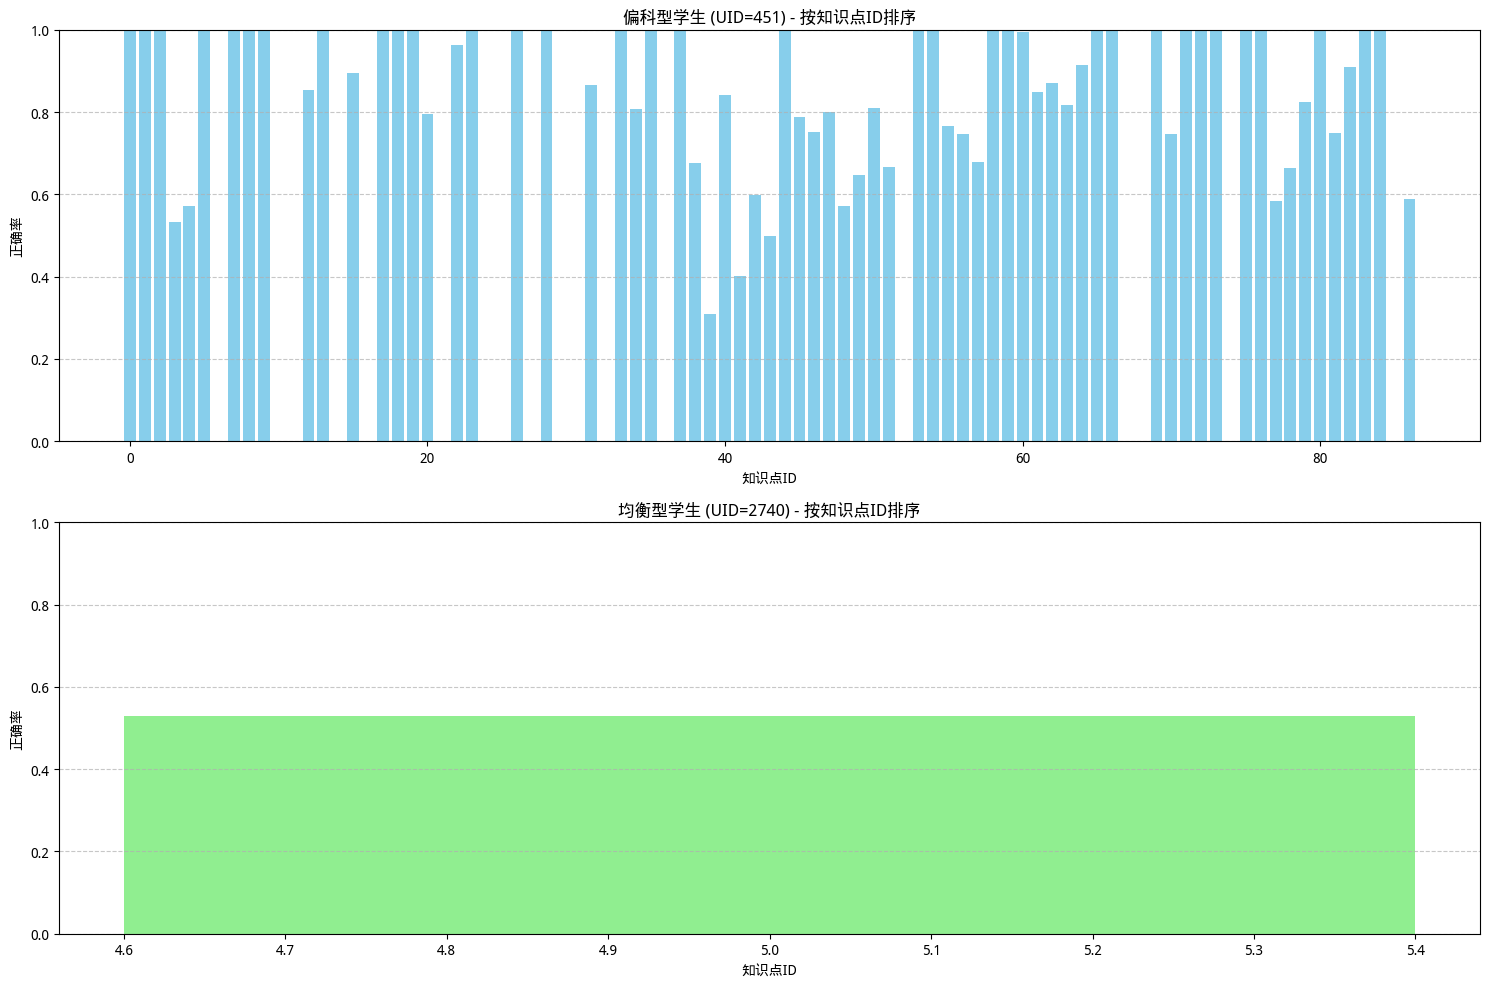

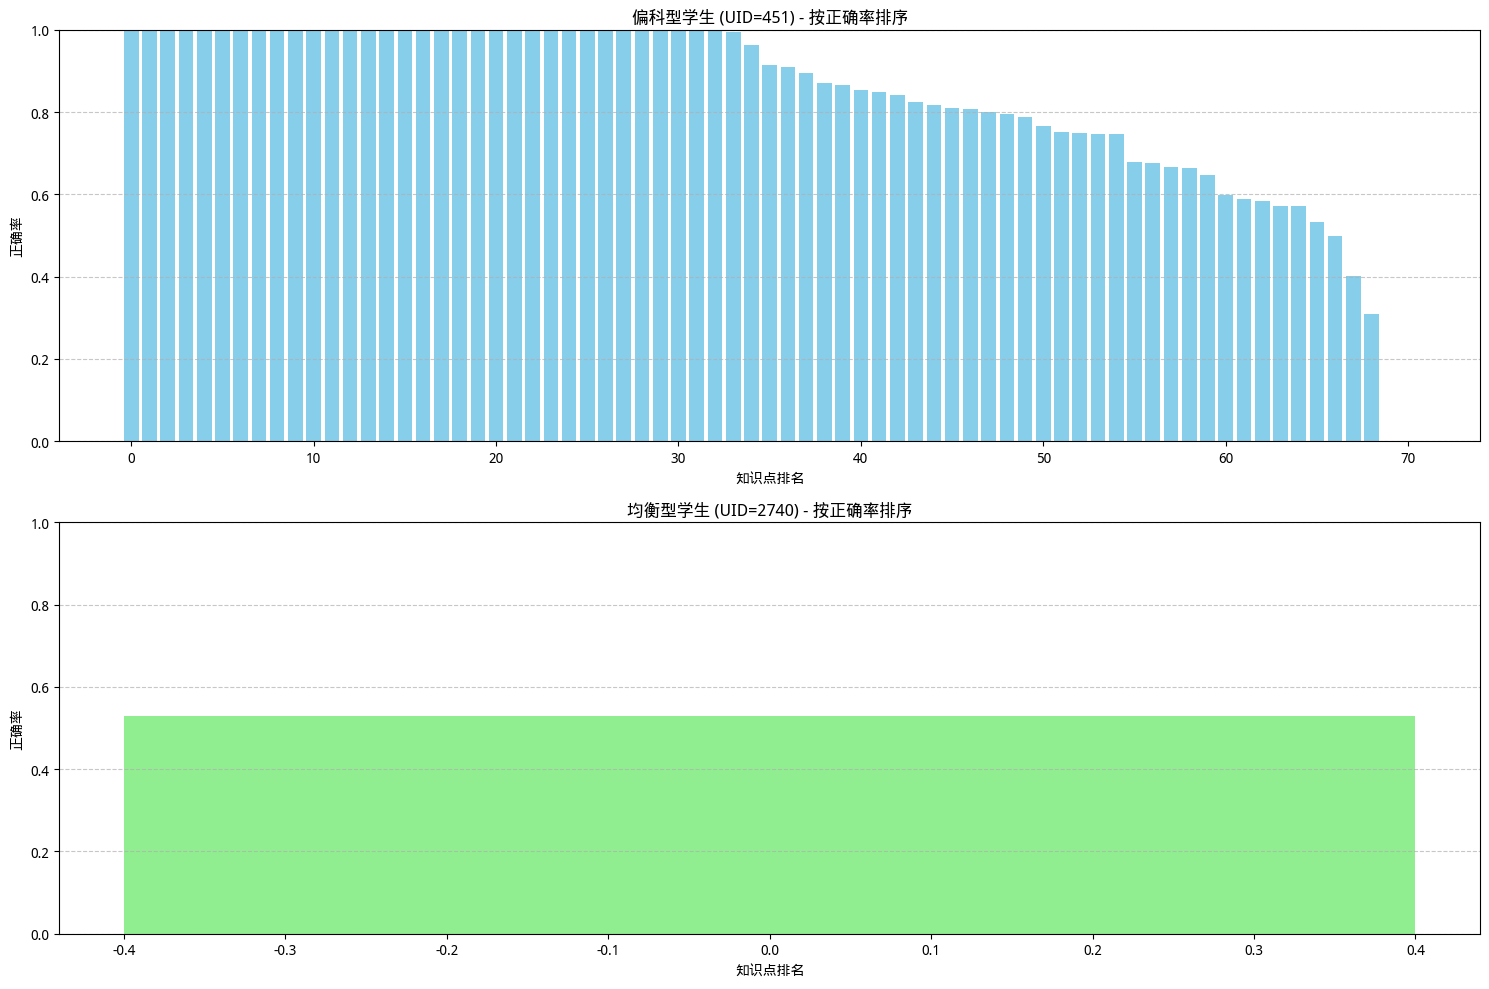

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
# 设置支持中文的字体中文字体支持
try:
    # 尝试使用系统中已有的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")

# 新增函数：获取学生知识点正确率
def get_student_concept_accuracies(uid_data: pd.DataFrame, min_records=15):
    """获取单个学生每个知识点的正确率"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return {}
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    concept_accuracies = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > min_records:
            accuracy = stats['correct'] / stats['total']
            concept_accuracies[concept] = accuracy
    
    return concept_accuracies

# 修改后的主函数


def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据正确率差值将学生分类，按记录比例划分偏科/均衡/普通型"""
    # 计算每个学生的方差和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    # 创建学生DataFrame并按方差降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('variance', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * aaa  # 偏科型目标记录数
    target_balanced = total_records * aaa  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（方差最大的前aaa比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（方差最小的后aaa比例记录）
    # 获取尚未分类的学生（普通型），按方差升序排序
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('variance', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    variance_mapping = student_df.set_index('uid')['variance'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df, 0.1)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    # 找出偏科型中差值最大的学生
    biased_students = student_summary[student_summary['student_type'] == '偏科型']
    if not biased_students.empty:
        top_biased_student = biased_students.iloc[0]['uid']
        print(f"\n偏科型中差值最大的学生: UID={top_biased_student}, 差值={biased_students.iloc[0]['variance']:.3f}")
    else:
        top_biased_student = None
    
    # 找出均衡型中差值最小的学生
    balanced_students = student_summary[student_summary['student_type'] == '均衡型']
    if not balanced_students.empty:
        # 按方差升序排序取第一个
        balanced_students_sorted = balanced_students.sort_values('variance')
        bottom_balanced_student = balanced_students_sorted.iloc[0]['uid']
        print(f"均衡型中差值最小的学生: UID={bottom_balanced_student}, 差值={balanced_students_sorted.iloc[0]['variance']:.3f}")
    else:
        bottom_balanced_student = None
    
    # 可视化部分
    if top_biased_student or bottom_balanced_student:
        print("\n正在生成可视化图表...")
        
        # 创建输出目录
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取学生数据
        biased_data = df_classified[df_classified['uid'] == top_biased_student] if top_biased_student else None
        balanced_data = df_classified[df_classified['uid'] == bottom_balanced_student] if bottom_balanced_student else None
        
        # 获取知识点正确率
        biased_acc = get_student_concept_accuracies(biased_data, 15) if biased_data is not None else {}
        balanced_acc = get_student_concept_accuracies(balanced_data, 15) if balanced_data is not None else {}
        
        # 图1：按知识点ID排序
        plt.figure(figsize=(15, 10))
        
        if biased_acc:
            # 偏科型学生知识点正确率（按ID排序）
            plt.subplot(2, 1, 1)
            concepts = sorted(biased_acc.keys())
            accuracies = [biased_acc[c] for c in concepts]
            plt.bar(concepts, accuracies, color='skyblue')
            plt.title(f'偏科型学生 (UID={top_biased_student}) - 按知识点ID排序')
            plt.xlabel('知识点ID')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        if balanced_acc:
            # 均衡型学生知识点正确率（按ID排序）
            plt.subplot(2, 1, 2)
            concepts = sorted(balanced_acc.keys())
            accuracies = [balanced_acc[c] for c in concepts]
            plt.bar(concepts, accuracies, color='lightgreen')
            plt.title(f'均衡型学生 (UID={bottom_balanced_student}) - 按知识点ID排序')
            plt.xlabel('知识点ID')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/concept_accuracy_by_id.png")
        print("已保存图表: concept_accuracy_by_id.png")
        
        # 图2：按正确率排序
        plt.figure(figsize=(15, 10))
        
        if biased_acc:
            # 偏科型学生知识点正确率（按正确率排序）
            plt.subplot(2, 1, 1)
            sorted_items = sorted(biased_acc.items(), key=lambda x: x[1], reverse=True)
            concepts = [item[0] for item in sorted_items]
            accuracies = [item[1] for item in sorted_items]
            plt.bar(range(len(accuracies)), accuracies, color='skyblue')
            plt.title(f'偏科型学生 (UID={top_biased_student}) - 按正确率排序')
            plt.xlabel('知识点排名')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        if balanced_acc:
            # 均衡型学生知识点正确率（按正确率排序）
            plt.subplot(2, 1, 2)
            sorted_items = sorted(balanced_acc.items(), key=lambda x: x[1], reverse=True)
            concepts = [item[0] for item in sorted_items]
            accuracies = [item[1] for item in sorted_items]
            plt.bar(range(len(accuracies)), accuracies, color='lightgreen')
            plt.title(f'均衡型学生 (UID={bottom_balanced_student}) - 按正确率排序')
            plt.xlabel('知识点排名')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/concept_accuracy_sorted.png")
        print("已保存图表: concept_accuracy_sorted.png")

    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df,取值比例)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance', 'valid_concept_average_num'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")
取值比例 = 0.1
知识点数量 = 15
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    # print("\n处理完成！")

## 差值加权重

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
题目数量 = 5
def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率差值
    使用前20%高正确率知识点和后20%低正确率知识点的平均正确率差值
    并根据知识点数量赋予权重
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 加权后的差值，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_concept_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 题目数量:  # 题量大于题目数量
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
    
    # 如果没有符合条件的知识点，返回0
    if not valid_concept_accuracies:
        return 0.0
    
    # 如果只有一个知识点，差值为0
    if len(valid_concept_accuracies) == 1:
        return 0.0
    
    # 按正确率排序
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    
    # 计算前20%和后20%的数量
    n_concepts = len(valid_concept_accuracies)
    # n_top = max(1, int(n_concepts * 0.2))  # 至少取1个
    # n_bottom = max(1, int(n_concepts * 0.2))  # 至少取1个
    n_top = 1
    n_bottom = 1
    # 获取前20%的知识点正确率
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    # 获取后20%的知识点正确率
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    # 计算平均值
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    # 计算原始差值
    raw_variance = avg_top - avg_bottom
    
    # 计算权重：知识点数量越多，权重越大
    # 使用对数函数使权重增长更平滑
    # 权重范围：[0.5, 1.5]
    if n_concepts <= 3:
        weight = 0.5  # 知识点很少时，权重较低
    elif n_concepts <= 5:
        weight = 0.7
    elif n_concepts <= 10:
        weight = 0.9
    elif n_concepts <= 20:
        weight = 1.0
    elif n_concepts <= 30:
        weight = 1.1
    elif n_concepts <= 50:
        weight = 1.2
    else:
        weight = 1.3 + 0.1 * np.log10(n_concepts / 50)  # 超过50个知识点后，权重继续缓慢增长
        weight = min(weight, 1.5)  # 权重上限为1.5
    
    # 返回加权后的差值
    weighted_variance = raw_variance * weight
    
    return weighted_variance

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率差值将学生分为三类，按记录数均衡分配
    前33%记录为偏科型，后33%记录为均衡型，中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的差值和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        variance = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count']
    
    # 按差值降序排序（差值大的在前）
    student_df = student_df.sort_values('variance', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['variance']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 计算并显示平均每个知识点的记录数
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            print(f"    平均每个知识点记录数: {avg_concept_num:.2f}")
            
            # 显示差值范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk1.csv"
    normal_output_path = f"{output_dir}/pt1.csv"
    balanced_output_path = f"{output_dir}/ph1.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    avg_specialized = student_summary[student_summary['student_type'] == '偏科型']['valid_concept_average_num'].mean()
    avg_normal = student_summary[student_summary['student_type'] == '普通型']['valid_concept_average_num'].mean()
    avg_balanced = student_summary[student_summary['student_type'] == '均衡型']['valid_concept_average_num'].mean()
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_specialized:.2f}")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_normal:.2f}")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_balanced:.2f}")

    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示差值最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("加权差值最大的3个学生:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',') if int(x) != -1]
            all_concepts.extend(concepts)
        unique_concepts = len(set(all_concepts))
        
        print(f"  UID={student['uid']}, 加权差值={student['variance']:.3f}, "
              f"类型={student['student_type']}, 知识点数={unique_concepts}")
    
    # 显示差值最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n加权差值最小的3个学生:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 加权差值={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示差值分布信息
    print(f"\n加权差值分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"标准差: {student_summary['variance'].std():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 标准差

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率标准差
    只考虑做题数量>5的知识点，计算这些知识点正确率的标准差
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 知识点正确率的标准差，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
    
    # 如果没有符合条件的知识点，返回0
    if not valid_accuracies:
        return 0.0
    
    # 如果只有一个知识点，标准差为0
    if len(valid_accuracies) == 1:
        return 0.0
    
    # 计算标准差
    std_dev = np.std(valid_accuracies, ddof=1)  # 使用样本标准差（ddof=1）
    
    return std_dev

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率标准差将学生分为三类，按记录数均衡分配
    前33%记录为偏科型（标准差大），后33%记录为均衡型（标准差小），中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的标准差和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        std_dev = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'std_dev': std_dev,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'std_dev', 'record_count']
    
    # 按标准差降序排序（标准差大的在前）
    student_df = student_df.sort_values('std_dev', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录，标准差大）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型（标准差小）
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['std_dev']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握标准差...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 显示该类型学生的标准差范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    标准差范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均标准差: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk2.csv"
    normal_output_path = f"{output_dir}/pt2.csv"
    balanced_output_path = f"{output_dir}/ph2.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示标准差最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("标准差最大的3个学生（偏科程度高）:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量和正确率分布
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        all_responses = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',')]
            responses = [int(x) for x in row['responses'].split(',')]
            valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
            if valid_pairs:
                all_concepts.extend([p[0] for p in valid_pairs])
                all_responses.extend([p[1] for p in valid_pairs])
        
        # 统计符合条件的知识点数
        concept_stats = {}
        for c, r in zip(all_concepts, all_responses):
            if c not in concept_stats:
                concept_stats[c] = {'correct': 0, 'total': 0}
            concept_stats[c]['total'] += 1
            if r == 1:
                concept_stats[c]['correct'] += 1
        
        valid_concepts = [c for c, stats in concept_stats.items() if stats['total'] > 5]
        
        print(f"  UID={student['uid']}, 标准差={student['variance']:.3f}, "
              f"类型={student['student_type']}, 有效知识点数={len(valid_concepts)}")
    
    # 显示标准差最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n标准差最小的3个学生（均衡程度高）:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 标准差={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示标准差分布信息
    print(f"\n标准差分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"平均值: {student_summary['variance'].mean():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 加权标准差

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率加权标准差
    只考虑做题数量>5的知识点，根据每个知识点的做题数量赋予权重
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 知识点正确率的加权标准差，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点，同时记录权重
    valid_data = []  # [(accuracy, weight)]
    total_weight = 0
    
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            # 权重：做题数量越多，权重越大（使用对数函数使权重增长更平滑）
            weight = np.log(stats['total'])  # 使用对数权重
            valid_data.append((accuracy, weight))
            total_weight += weight
    
    # 如果没有符合条件的知识点，返回0
    if not valid_data:
        return 0.0
    
    # 如果只有一个知识点，标准差为0
    if len(valid_data) == 1:
        return 0.0
    
    # 计算加权平均值
    weighted_mean = sum(acc * w for acc, w in valid_data) / total_weight
    
    # 计算加权方差
    weighted_variance = sum(w * (acc - weighted_mean) ** 2 for acc, w in valid_data) / total_weight
    
    # 计算加权标准差
    weighted_std = np.sqrt(weighted_variance)
    
    # 贝塞尔校正：对于样本标准差的修正
    # 使用类似于样本标准差的校正因子
    n = len(valid_data)
    correction_factor = np.sqrt(n / (n - 1)) if n > 1 else 1
    corrected_weighted_std = weighted_std * correction_factor
    
    return corrected_weighted_std

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率加权标准差将学生分为三类，按记录数均衡分配
    前33%记录为偏科型（加权标准差大），后33%记录为均衡型（加权标准差小），中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的加权标准差和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        weighted_std = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'weighted_std': weighted_std,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'weighted_std', 'record_count']
    
    # 按加权标准差降序排序（加权标准差大的在前）
    student_df = student_df.sort_values('weighted_std', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录，加权标准差大）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型（加权标准差小）
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['weighted_std']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握加权标准差...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 显示该类型学生的加权标准差范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    加权标准差范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均加权标准差: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk3.csv"
    normal_output_path = f"{output_dir}/pt3.csv"
    balanced_output_path = f"{output_dir}/ph3.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示加权标准差最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("加权标准差最大的3个学生（偏科程度高）:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量和正确率分布
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        all_responses = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',')]
            responses = [int(x) for x in row['responses'].split(',')]
            valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
            if valid_pairs:
                all_concepts.extend([p[0] for p in valid_pairs])
                all_responses.extend([p[1] for p in valid_pairs])
        
        # 统计符合条件的知识点数和总题量
        concept_stats = {}
        for c, r in zip(all_concepts, all_responses):
            if c not in concept_stats:
                concept_stats[c] = {'correct': 0, 'total': 0}
            concept_stats[c]['total'] += 1
            if r == 1:
                concept_stats[c]['correct'] += 1
        
        valid_concepts = [(c, stats) for c, stats in concept_stats.items() if stats['total'] > 5]
        total_questions = sum(stats['total'] for _, stats in valid_concepts)
        
        print(f"  UID={student['uid']}, 加权标准差={student['variance']:.3f}, "
              f"类型={student['student_type']}, 有效知识点数={len(valid_concepts)}, "
              f"总题量={total_questions}")
    
    # 显示加权标准差最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n加权标准差最小的3个学生（均衡程度高）:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 加权标准差={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示加权标准差分布信息
    print(f"\n加权标准差分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"平均值: {student_summary['variance'].mean():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 变异系数法

In [7]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict

def calculate_student_cv(uid_data: pd.DataFrame, min_concept_count: int) -> Tuple[float, float]:
    """计算单个学生的知识点正确率变异系数(CV)及平均知识点记录数"""
    concept_stats: Dict[int, Dict[str, int]] = {}
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤无效记录
        for concept, response in zip(concepts, responses):
            if concept == -1 or response == -1:
                continue
                
            if concept not in concept_stats:
                concept_stats[concept] = {'correct': 0, 'total': 0}
            
            concept_stats[concept]['total'] += 1
            if response == 1:
                concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    valid_accuracies = []
    valid_counts = []
    
    for stats in concept_stats.values():
        if stats['total'] >= min_concept_count:
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
            valid_counts.append(stats['total'])
    
    # 计算变异系数(CV)
    if len(valid_accuracies) < 2:
        # 不足2个知识点无法计算变异系数
        return 0.0, 0.0
    
    mean_accuracy = np.mean(valid_accuracies)
    std_accuracy = np.std(valid_accuracies)
    
    # 避免除以零（当所有知识点正确率完全相同时）
    # cv = std_accuracy / mean_accuracy if mean_accuracy > 1e-6 else 0.0
    cv = std_accuracy  if mean_accuracy > 1e-6 else 0.0
    avg_count = np.mean(valid_counts) if valid_counts else 0.0
    
    return cv, avg_count

def classify_students_by_cv(df: pd.DataFrame, ratio: float, min_concept_count: int) -> pd.DataFrame:
    """根据变异系数(CV)将学生分类"""
    # 计算每个学生的CV和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        cv, avg_count = calculate_student_cv(group, min_concept_count)
        record_count = len(group)
        student_info[uid] = {
            'cv': cv,
            'record_count': record_count,
            'avg_concept_count': avg_count
        }
    
    # 创建学生DataFrame并按CV降序排序（CV越大越偏科）
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'cv', 'record_count', 'avg_concept_count']
    student_df = student_df.sort_values('cv', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * ratio  # 偏科型目标记录数
    target_balanced = total_records * ratio  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（CV最大的前ratio比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（CV最小的后ratio比例记录）
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('cv', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    cv_mapping = student_df.set_index('uid')['cv'].to_dict()
    count_mapping = student_df.set_index('uid')['avg_concept_count'].to_dict()
    
    df['cv'] = df['uid'].map(cv_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['avg_concept_count'] = df['uid'].map(count_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './', ratio: float = 0.1, min_concept_count: int = 15):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点变异系数(CV)...")
    df_classified = classify_students_by_cv(df, ratio, min_concept_count)
    
    student_summary = df_classified[['uid', 'student_type', 'cv', 'avg_concept_count']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_count = student_summary[student_summary['student_type'] == student_type]['avg_concept_count'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_count:.2f}")
            
            type_cv = student_summary[student_summary['student_type'] == student_type]['cv']
            if len(type_cv) > 0:
                print(f"    CV范围: {type_cv.min():.3f} - {type_cv.max():.3f}")
                print(f"    平均CV: {type_cv.mean():.3f}")
    
    # 保存分类结果
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'cv', 'avg_concept_count'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    
    # 参数设置
    RATIO = 0.1  # 偏科/均衡型学生记录数占总记录数的比例
    MIN_CONCEPT_COUNT = 15  # 知识点最小记录数阈值
    
    main(input_file, output_directory, ratio=RATIO, min_concept_count=MIN_CONCEPT_COUNT)
    print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点变异系数(CV)...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 3261 (10.7%)
    学生数: 56 (7.3%)
    平均知识点记录数: 303.97
    CV范围: 0.315 - 0.444
    平均CV: 0.355

  普通型:
    记录数: 24222 (79.1%)
    学生数: 195 (25.3%)
    平均知识点记录数: 453.15
    CV范围: 0.148 - 0.313
    平均CV: 0.225

  均衡型:
    记录数: 3127 (10.2%)
    学生数: 519 (67.4%)
    平均知识点记录数: 19.48
    CV范围: 0.000 - 0.147
    平均CV: 0.014

数据保存详情:
偏科型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pk.csv | 记录数: 3261 | 学生数: 56
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pt.csv | 记录数: 24222 | 学生数: 195
均衡型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//ph.csv | 记录数: 3127 | 学生数: 519

处理完成！


## 相对偏科

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict

def calculate_student_cv(uid_data: pd.DataFrame, min_concept_count: int) -> Tuple[float, float]:
    """计算单个学生的知识点正确率变异系数(CV)及平均知识点记录数"""
    concept_stats: Dict[int, Dict[str, int]] = {}
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤无效记录
        for concept, response in zip(concepts, responses):
            if concept == -1 or response == -1:
                continue
                
            if concept not in concept_stats:
                concept_stats[concept] = {'correct': 0, 'total': 0}
            
            concept_stats[concept]['total'] += 1
            if response == 1:
                concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    valid_accuracies = []
    valid_counts = []
    
    for stats in concept_stats.values():
        if stats['total'] >= min_concept_count:
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
            valid_counts.append(stats['total'])
    
    # 计算变异系数(CV)
    if len(valid_accuracies) < 2:
        # 不足2个知识点无法计算变异系数
        return 0.0, 0.0
    
    mean_accuracy = np.mean(valid_accuracies)
    std_accuracy = np.std(valid_accuracies)
    
    # 避免除以零（当所有知识点正确率完全相同时）
    cv = std_accuracy / mean_accuracy if mean_accuracy > 1e-6 else 0.0
    avg_count = np.mean(valid_counts) if valid_counts else 0.0
    
    return cv, avg_count

def classify_students_by_cv(df: pd.DataFrame, ratio: float, min_concept_count: int) -> pd.DataFrame:
    """根据变异系数(CV)将学生分类"""
    # 计算每个学生的CV和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        cv, avg_count = calculate_student_cv(group, min_concept_count)
        record_count = len(group)
        student_info[uid] = {
            'cv': cv,
            'record_count': record_count,
            'avg_concept_count': avg_count
        }
    
    # 创建学生DataFrame并按CV降序排序（CV越大越偏科）
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'cv', 'record_count', 'avg_concept_count']
    student_df = student_df.sort_values('cv', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * ratio  # 偏科型目标记录数
    target_balanced = total_records * ratio  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（CV最大的前ratio比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（CV最小的后ratio比例记录）
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('cv', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    cv_mapping = student_df.set_index('uid')['cv'].to_dict()
    count_mapping = student_df.set_index('uid')['avg_concept_count'].to_dict()
    
    df['cv'] = df['uid'].map(cv_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['avg_concept_count'] = df['uid'].map(count_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './', ratio: float = 0.1, min_concept_count: int = 15):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点变异系数(CV)...")
    df_classified = classify_students_by_cv(df, ratio, min_concept_count)
    
    student_summary = df_classified[['uid', 'student_type', 'cv', 'avg_concept_count']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_count = student_summary[student_summary['student_type'] == student_type]['avg_concept_count'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_count:.2f}")
            
            type_cv = student_summary[student_summary['student_type'] == student_type]['cv']
            if len(type_cv) > 0:
                print(f"    CV范围: {type_cv.min():.3f} - {type_cv.max():.3f}")
                print(f"    平均CV: {type_cv.mean():.3f}")
    
    # 保存分类结果
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'cv', 'avg_concept_count'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    
    # 参数设置
    RATIO = 0.1  # 偏科/均衡型学生记录数占总记录数的比例
    MIN_CONCEPT_COUNT = 15  # 知识点最小记录数阈值
    
    main(input_file, output_directory, ratio=RATIO, min_concept_count=MIN_CONCEPT_COUNT)
    print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握排名差异...
正在计算知识点排名...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 10477 (34.2%)
    学生数: 120 (15.6%)
    排名差异范围: 129 - 206
    平均排名差异: 154.3

  普通型:
    记录数: 10177 (33.2%)
    学生数: 108 (14.0%)
    排名差异范围: 97 - 128
    平均排名差异: 111.6

  均衡型:
    记录数: 9956 (32.5%)
    学生数: 542 (70.4%)
    排名差异范围: 0 - 96
    平均排名差异: 22.3

数据已保存:
偏科型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//pk5.csv (10477 条记录, 120 个学生)
普通型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//pt5.csv (10177 条记录, 108 个学生)
均衡型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//ph5.csv (9956 条记录, 542 个学生)

示例分析:
排名差异最大的3个学生（偏科程度高）:
  UID=1020, 排名差异=206, 类型=偏科型, 有效知识点数=39, 最高排名=1, 最低排名=207
  UID=1028, 排名差异=206, 类型=偏科型, 有效知识点数=43, 最高排名=1, 最低排名=207
  UID=1082, 排名差异=205, 类型=偏科型, 有效知识点数=20, 最高排名=1, 最低排名=206

排名差异最小的3个学生（均衡程度高）:
  UID=2618, 排名差异=0, 类型=均衡型
  UID=1542, 排名差异=0, 类型=均衡型
  UID=2243, 排名差异=0, 类型=均衡型

排名差异分布统计:
最小值: 0
25%分位数: 0
中位数: 37
75%分位数: 